In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pydicom
import seaborn as sns

from fastprogress import master_bar, progress_bar
from glob import glob
from IPython import display
from matplotlib import animation

# tabular

In [2]:
base_dir  = './input/osic-pulmonary-fibrosis-progression/'

# construct train df

In [3]:
train_df = pd.read_csv(base_dir + 'train.csv')
output = pd.DataFrame()

gb = train_df.groupby('Patient')
tqdm = progress_bar(gb, total=len(gb))

for ID, usr_df in tqdm:
    usr_output = pd.DataFrame()
    for week, tmp_df in usr_df.groupby('Weeks'):

        rename_cols = {
            'Weeks': 'base_Week',
            'FVC': 'base_FVC',
            'Percent': 'base_Percent',
        }
        tmp_df = tmp_df.rename(columns=rename_cols)
        
        drop_cols = ['Age', 'Sex', 'SmokingStatus', 'Percent']
        _usr_op = usr_df.drop(columns=drop_cols)
        _usr_op = _usr_op.rename(columns={'Weeks': 'target_week'})
        _usr_op = _usr_op.merge(tmp_df, on='Patient')
        _usr_op['weeks_passed'] = _usr_op['target_week'] - _usr_op['base_Week']
        
        usr_output = pd.concat([usr_output, _usr_op])
    output = pd.concat([output, usr_output])

#train = output[output['Week_passed'] != 0].reset_index(drop=True)
train_df = output.reset_index(drop=True)

train_df['phase'] = 'train'
print(train_df.shape)

train_df = train_df[train_df.weeks_passed > 0]
train_df

(13707, 11)


Patient  target_week   FVC  base_Week  base_FVC  \
1      ID00007637202177411956430            5  2214         -4      2315   
2      ID00007637202177411956430            7  2061         -4      2315   
3      ID00007637202177411956430            9  2144         -4      2315   
4      ID00007637202177411956430           11  2069         -4      2315   
5      ID00007637202177411956430           17  2101         -4      2315   
...                          ...          ...   ...        ...       ...   
13678  ID00426637202313170790466           43  2975         19      2978   
13679  ID00426637202313170790466           59  2774         19      2978   
13687  ID00426637202313170790466           43  2975         31      2908   
13688  ID00426637202313170790466           59  2774         31      2908   
13697  ID00426637202313170790466           59  2774         43      2975   

       base_Percent  Age   Sex SmokingStatus  weeks_passed  phase  
1         58.253649   79  Male     Ex-smoker             9  train  
2         58.253649   79  Male     Ex-smoker            11  train  
3         58.253649   79  Male     Ex-smoker            13  train  
4         58.253649   79  Male     Ex-smoker            15  train  
5         58.253649   79  Male     Ex-smoker            21  train  
...             ...  ...   ...           ...           ...    ...  
13678     73.126412   73  Male  Never smoked            24  train  
13679     73.126412   73  Male  Never smoked            40  train  
13687     71.407524   73  Male  Never smoked            12  train  
13688     71.407524   73  Male  Never smoked            28  train  
13697     73.052745   73  Male  Never smoked            16  train  

[6072 rows x 11 columns]

# feature

In [4]:
train_df['percent_reciprocal'] = 1 / train_df.base_Percent
train_df['percent_ratio'] = train_df.base_FVC / train_df.base_Percent

def calculate_height(row):
    height = 0
    if row['Sex'] == 'Male' or 'Female':
        height = (((row['base_FVC'] / 933.33) + 0.026 * row['Age'] + 2.89) /
                  0.0443)
        return int(height)


train_df['Height'] = train_df.apply(calculate_height, axis=1)


def FEV1(row):
    FEV = 0
    if row['Sex'] == 'Male':
        FEV = (0.84 * row['base_FVC'] - 0.23)
    else:
        FEV = (0.84 * row['base_FVC'] - 0.36)
    return FEV


train_df['FEV'] = train_df.apply(FEV1, axis=1)
train_df['FEV_ratio'] = train_df.FEV / train_df.base_FVC

train_df

Patient  target_week   FVC  base_Week  base_FVC  \
1      ID00007637202177411956430            5  2214         -4      2315   
2      ID00007637202177411956430            7  2061         -4      2315   
3      ID00007637202177411956430            9  2144         -4      2315   
4      ID00007637202177411956430           11  2069         -4      2315   
5      ID00007637202177411956430           17  2101         -4      2315   
...                          ...          ...   ...        ...       ...   
13678  ID00426637202313170790466           43  2975         19      2978   
13679  ID00426637202313170790466           59  2774         19      2978   
13687  ID00426637202313170790466           43  2975         31      2908   
13688  ID00426637202313170790466           59  2774         31      2908   
13697  ID00426637202313170790466           59  2774         43      2975   

       base_Percent  Age   Sex SmokingStatus  weeks_passed  phase  \
1         58.253649   79  Male     Ex-smoker             9  train   
2         58.253649   79  Male     Ex-smoker            11  train   
3         58.253649   79  Male     Ex-smoker            13  train   
4         58.253649   79  Male     Ex-smoker            15  train   
5         58.253649   79  Male     Ex-smoker            21  train   
...             ...  ...   ...           ...           ...    ...   
13678     73.126412   73  Male  Never smoked            24  train   
13679     73.126412   73  Male  Never smoked            40  train   
13687     71.407524   73  Male  Never smoked            12  train   
13688     71.407524   73  Male  Never smoked            28  train   
13697     73.052745   73  Male  Never smoked            16  train   

       percent_reciprocal  percent_ratio  Height      FEV  FEV_ratio  
1                0.017166         39.740     167  1944.37   0.839901  
2                0.017166         39.740     167  1944.37   0.839901  
3                0.017166         39.740     167  1944.37   0.839901  
4                0.017166         39.740     167  1944.37   0.839901  
5                0.017166         39.740     167  1944.37   0.839901  
...                   ...            ...     ...      ...        ...  
13678            0.013675         40.724     180  2501.29   0.839923  
13679            0.013675         40.724     180  2501.29   0.839923  
13687            0.014004         40.724     178  2442.49   0.839921  
13688            0.014004         40.724     178  2442.49   0.839921  
13697            0.013689         40.724     180  2498.77   0.839923  

[6072 rows x 16 columns]

C:\Users\utl\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


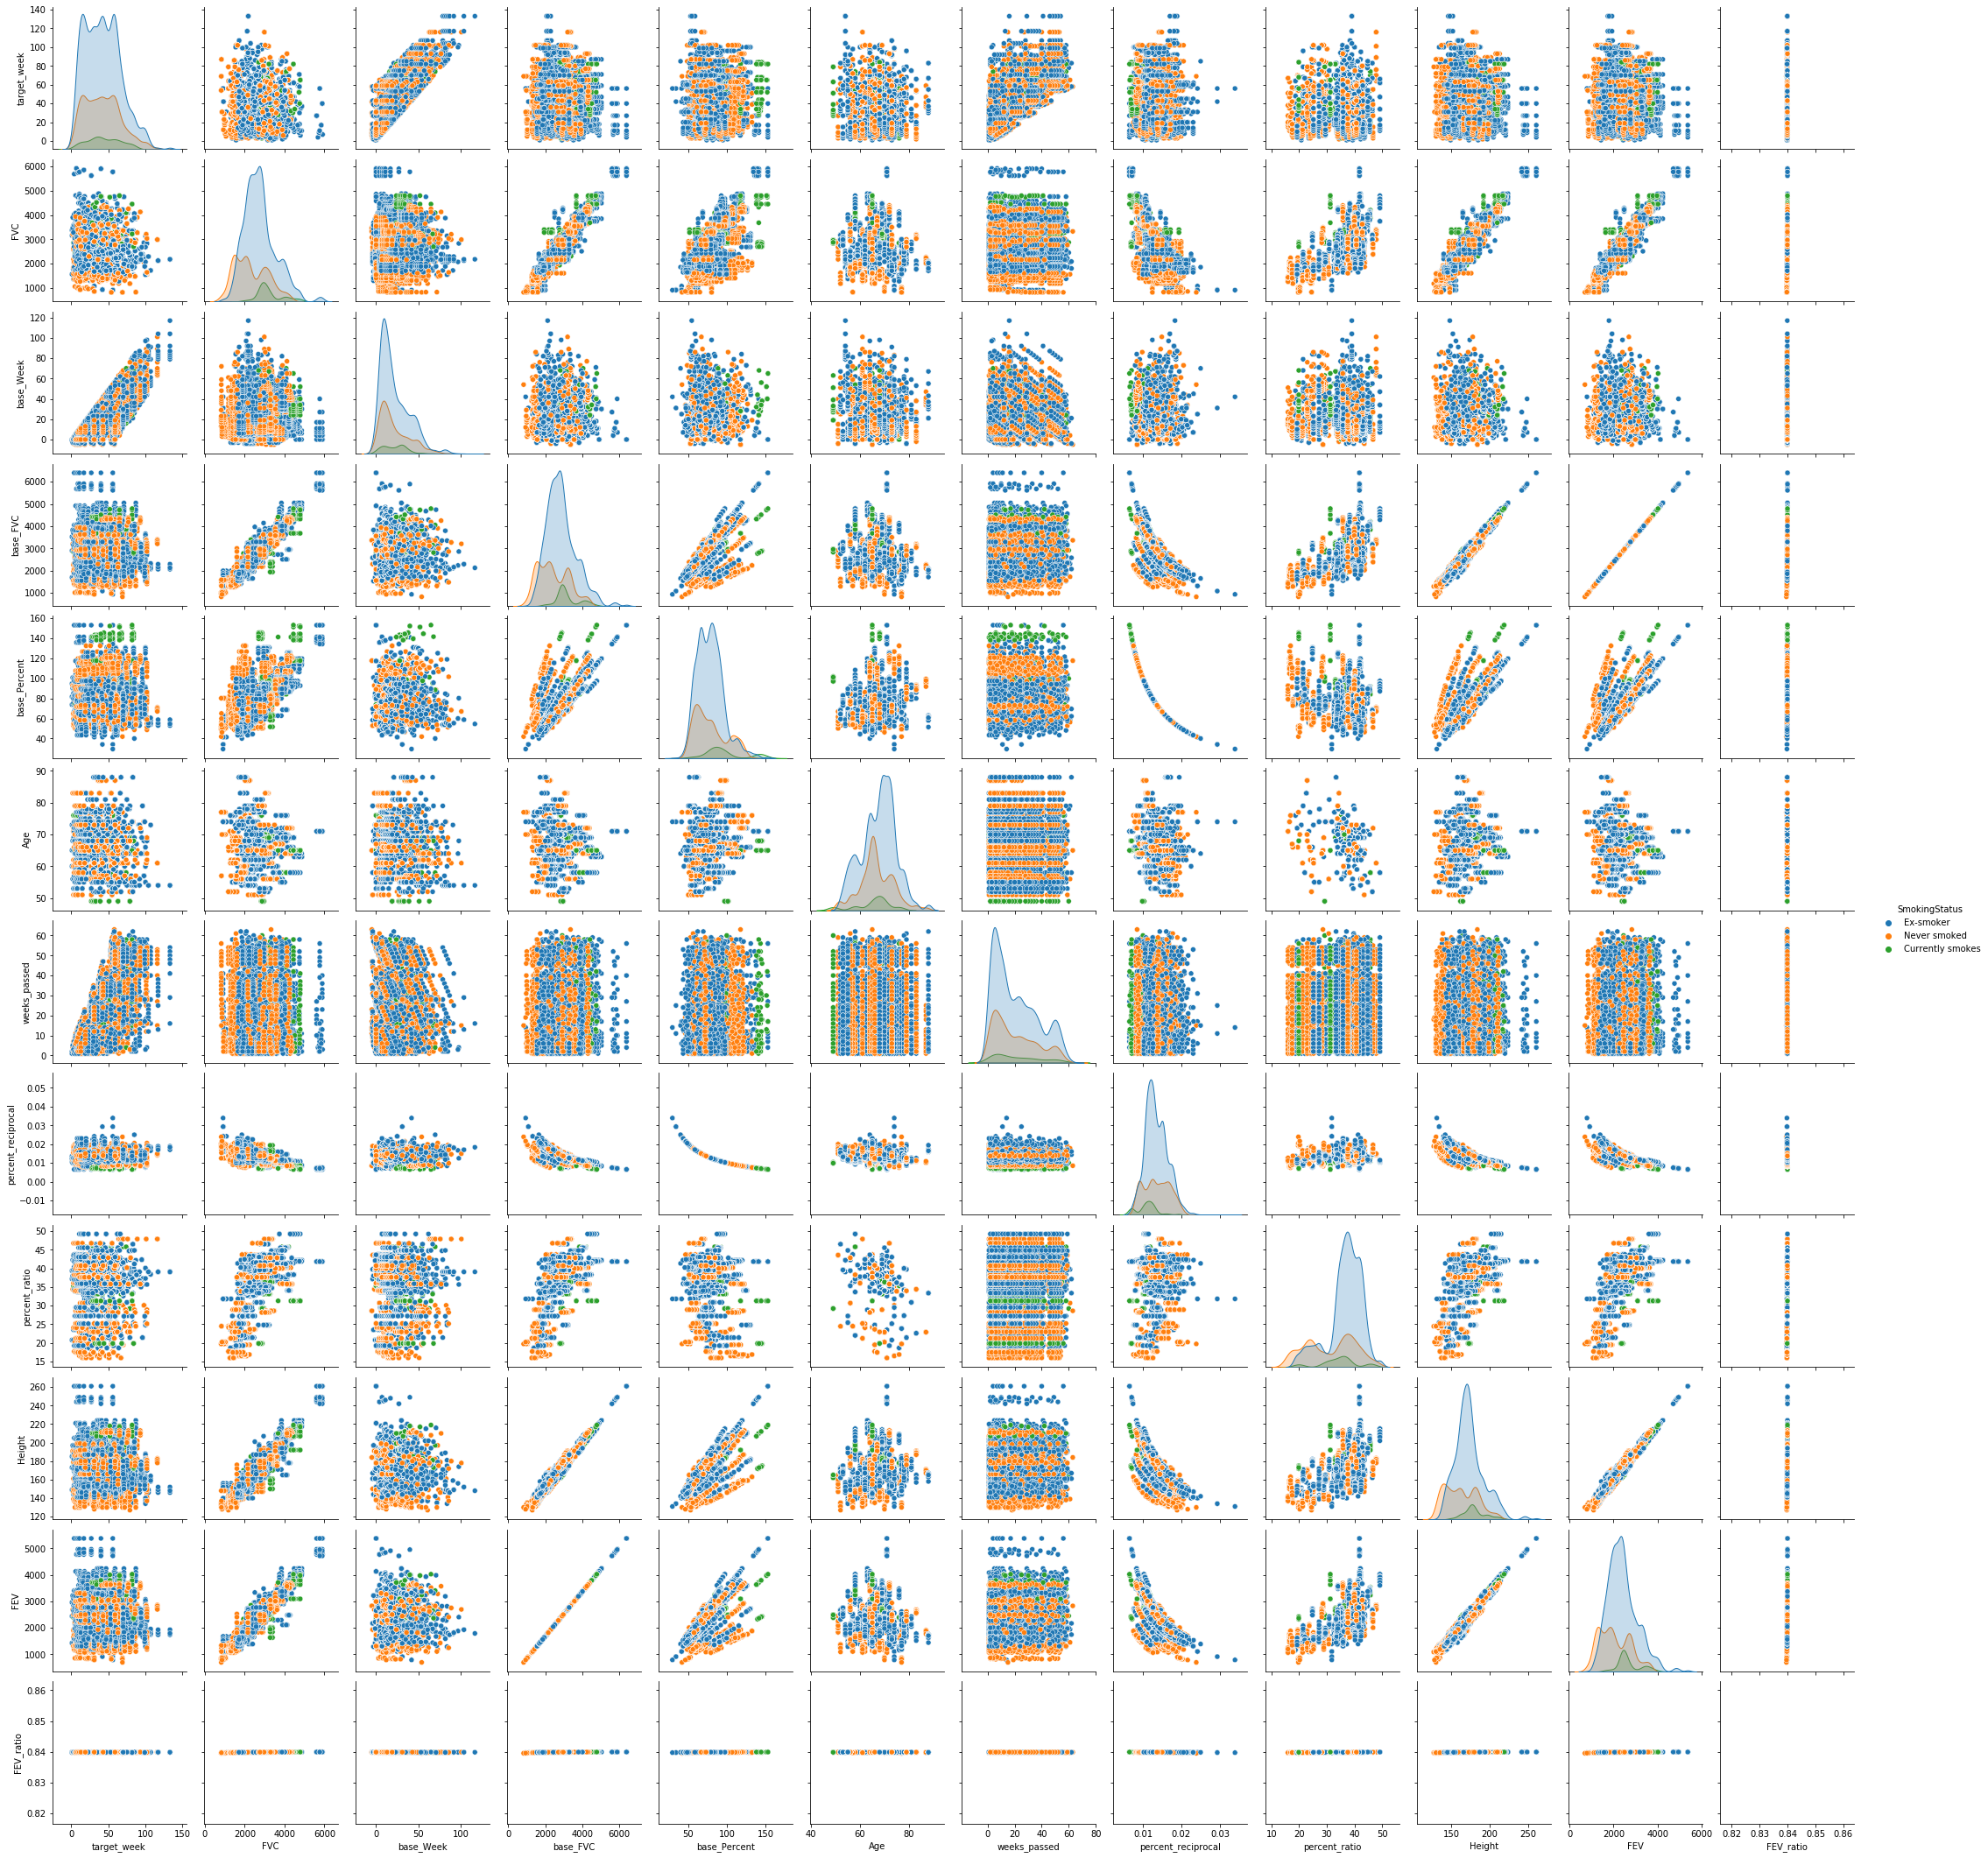

In [5]:
sns.pairplot(train_df, hue='SmokingStatus')

C:\Users\utl\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


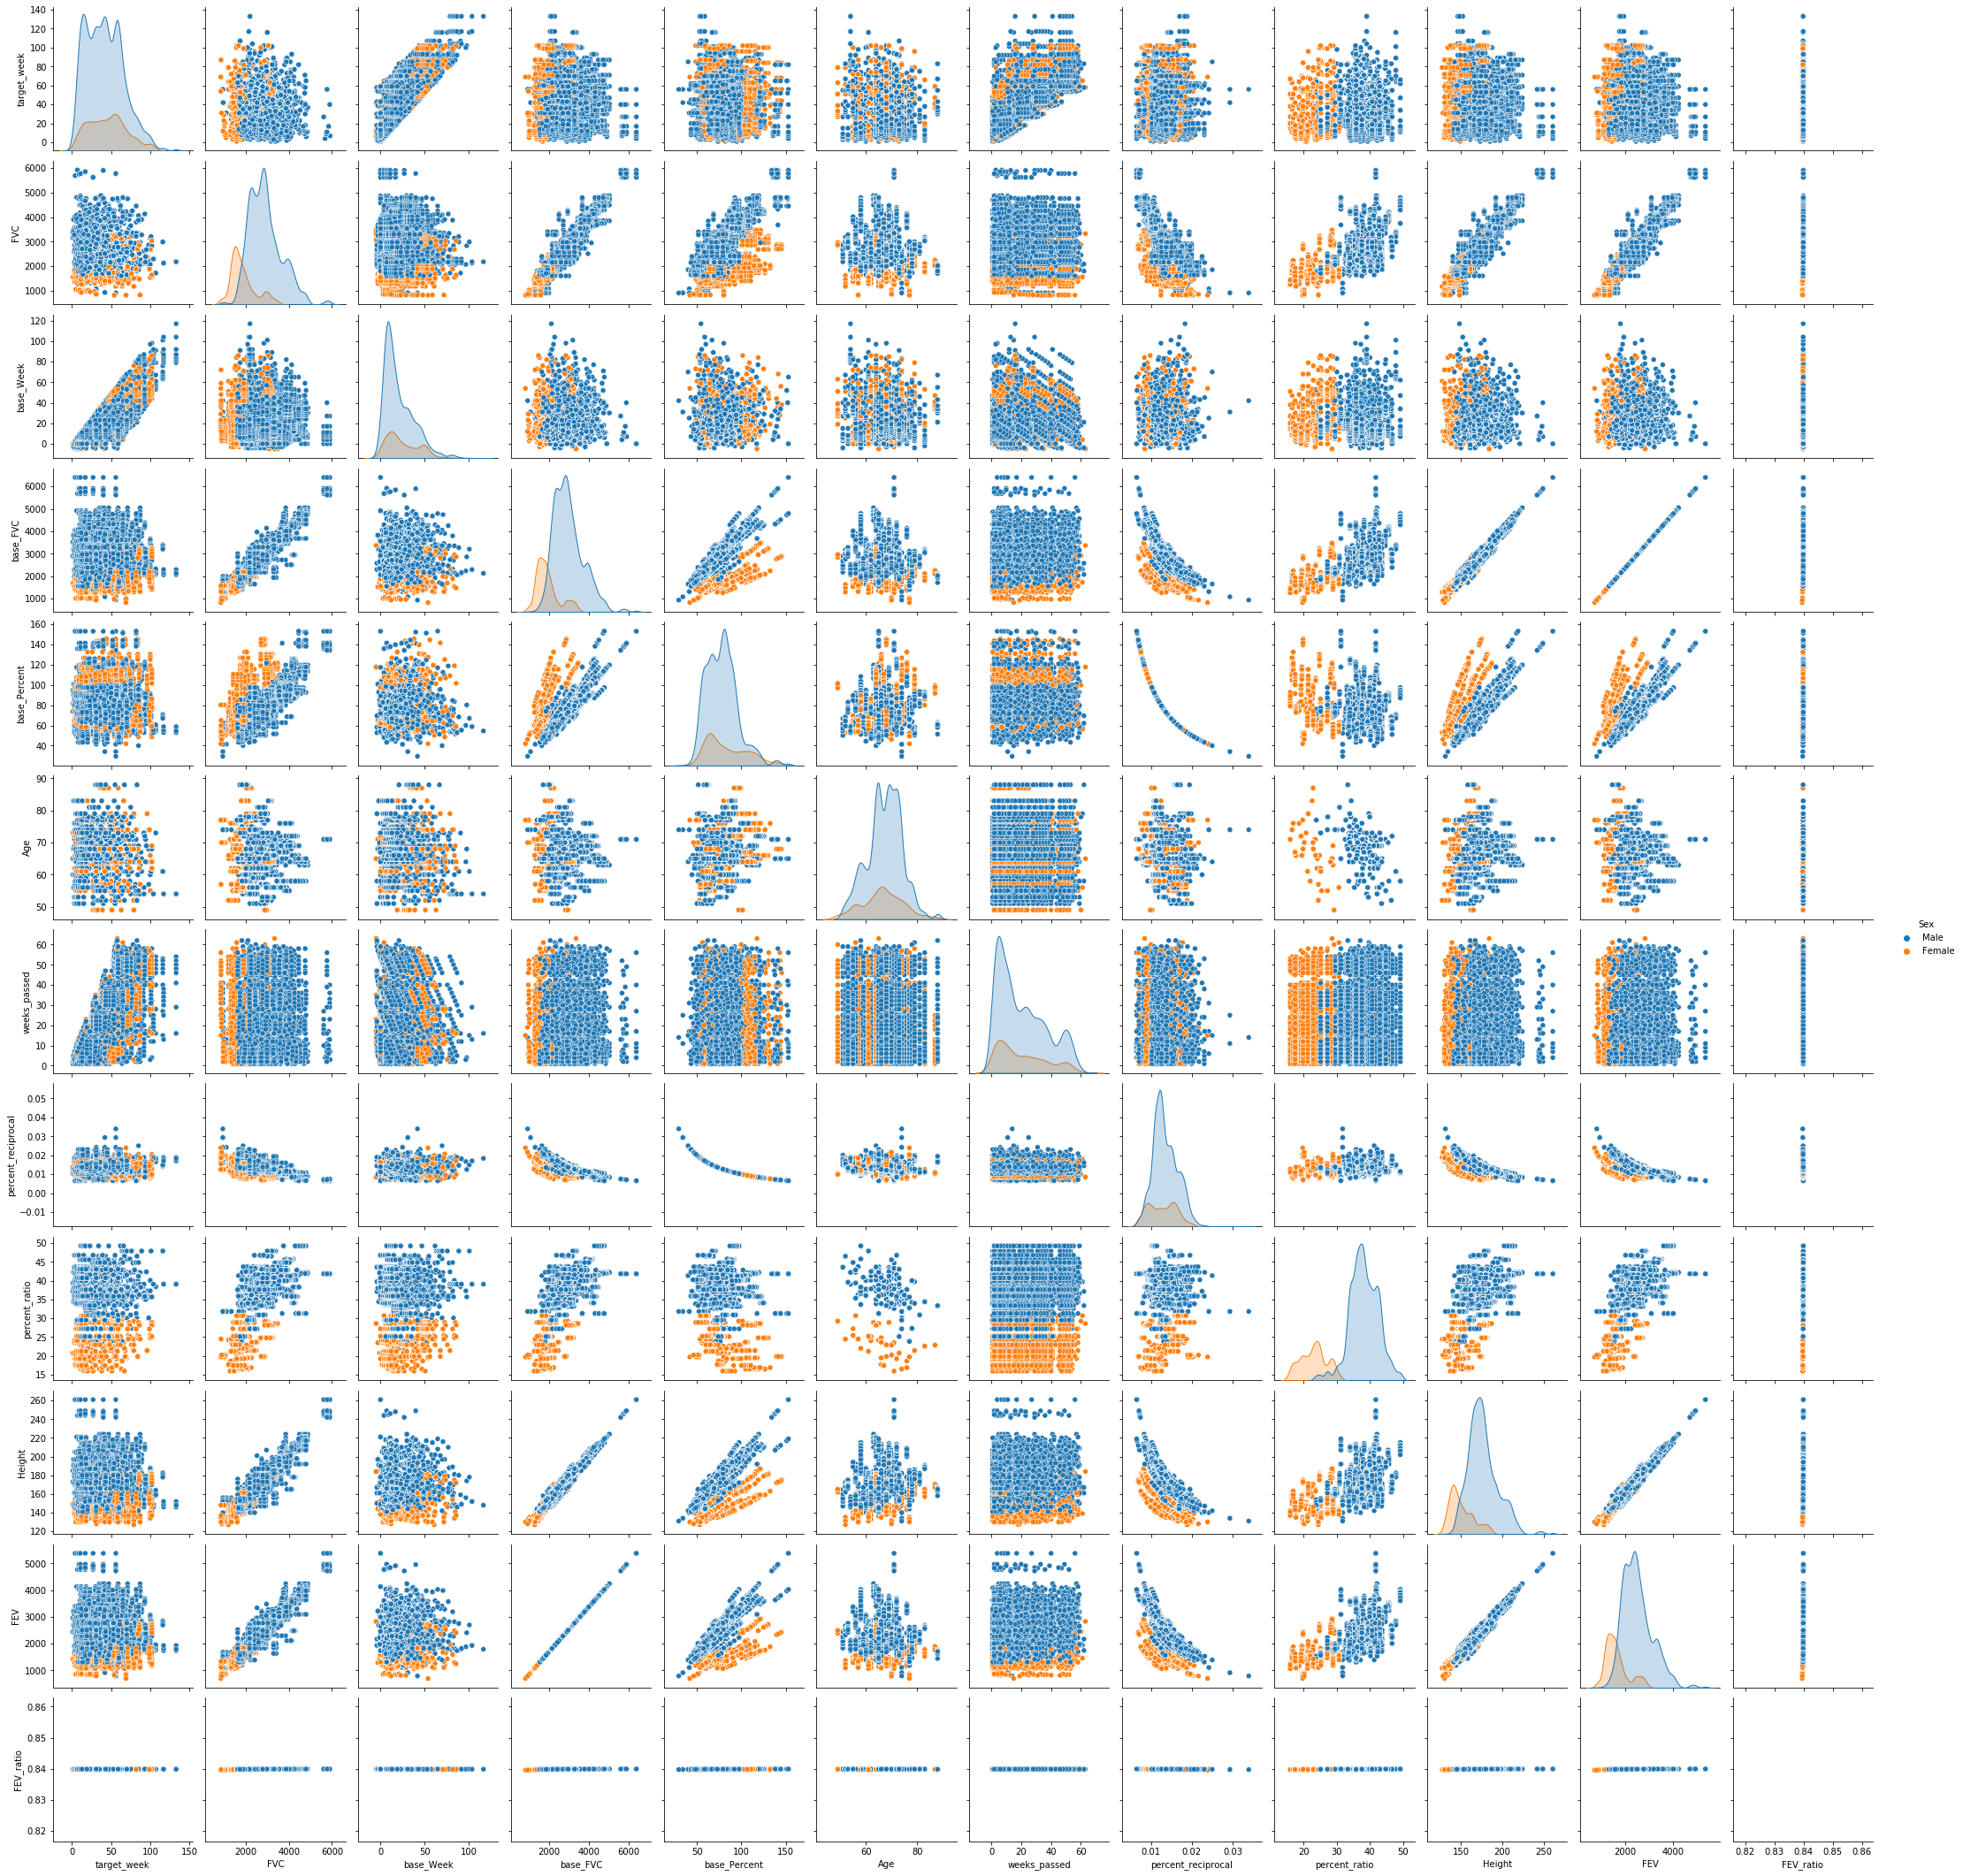

In [6]:
sns.pairplot(train_df, hue='Sex')

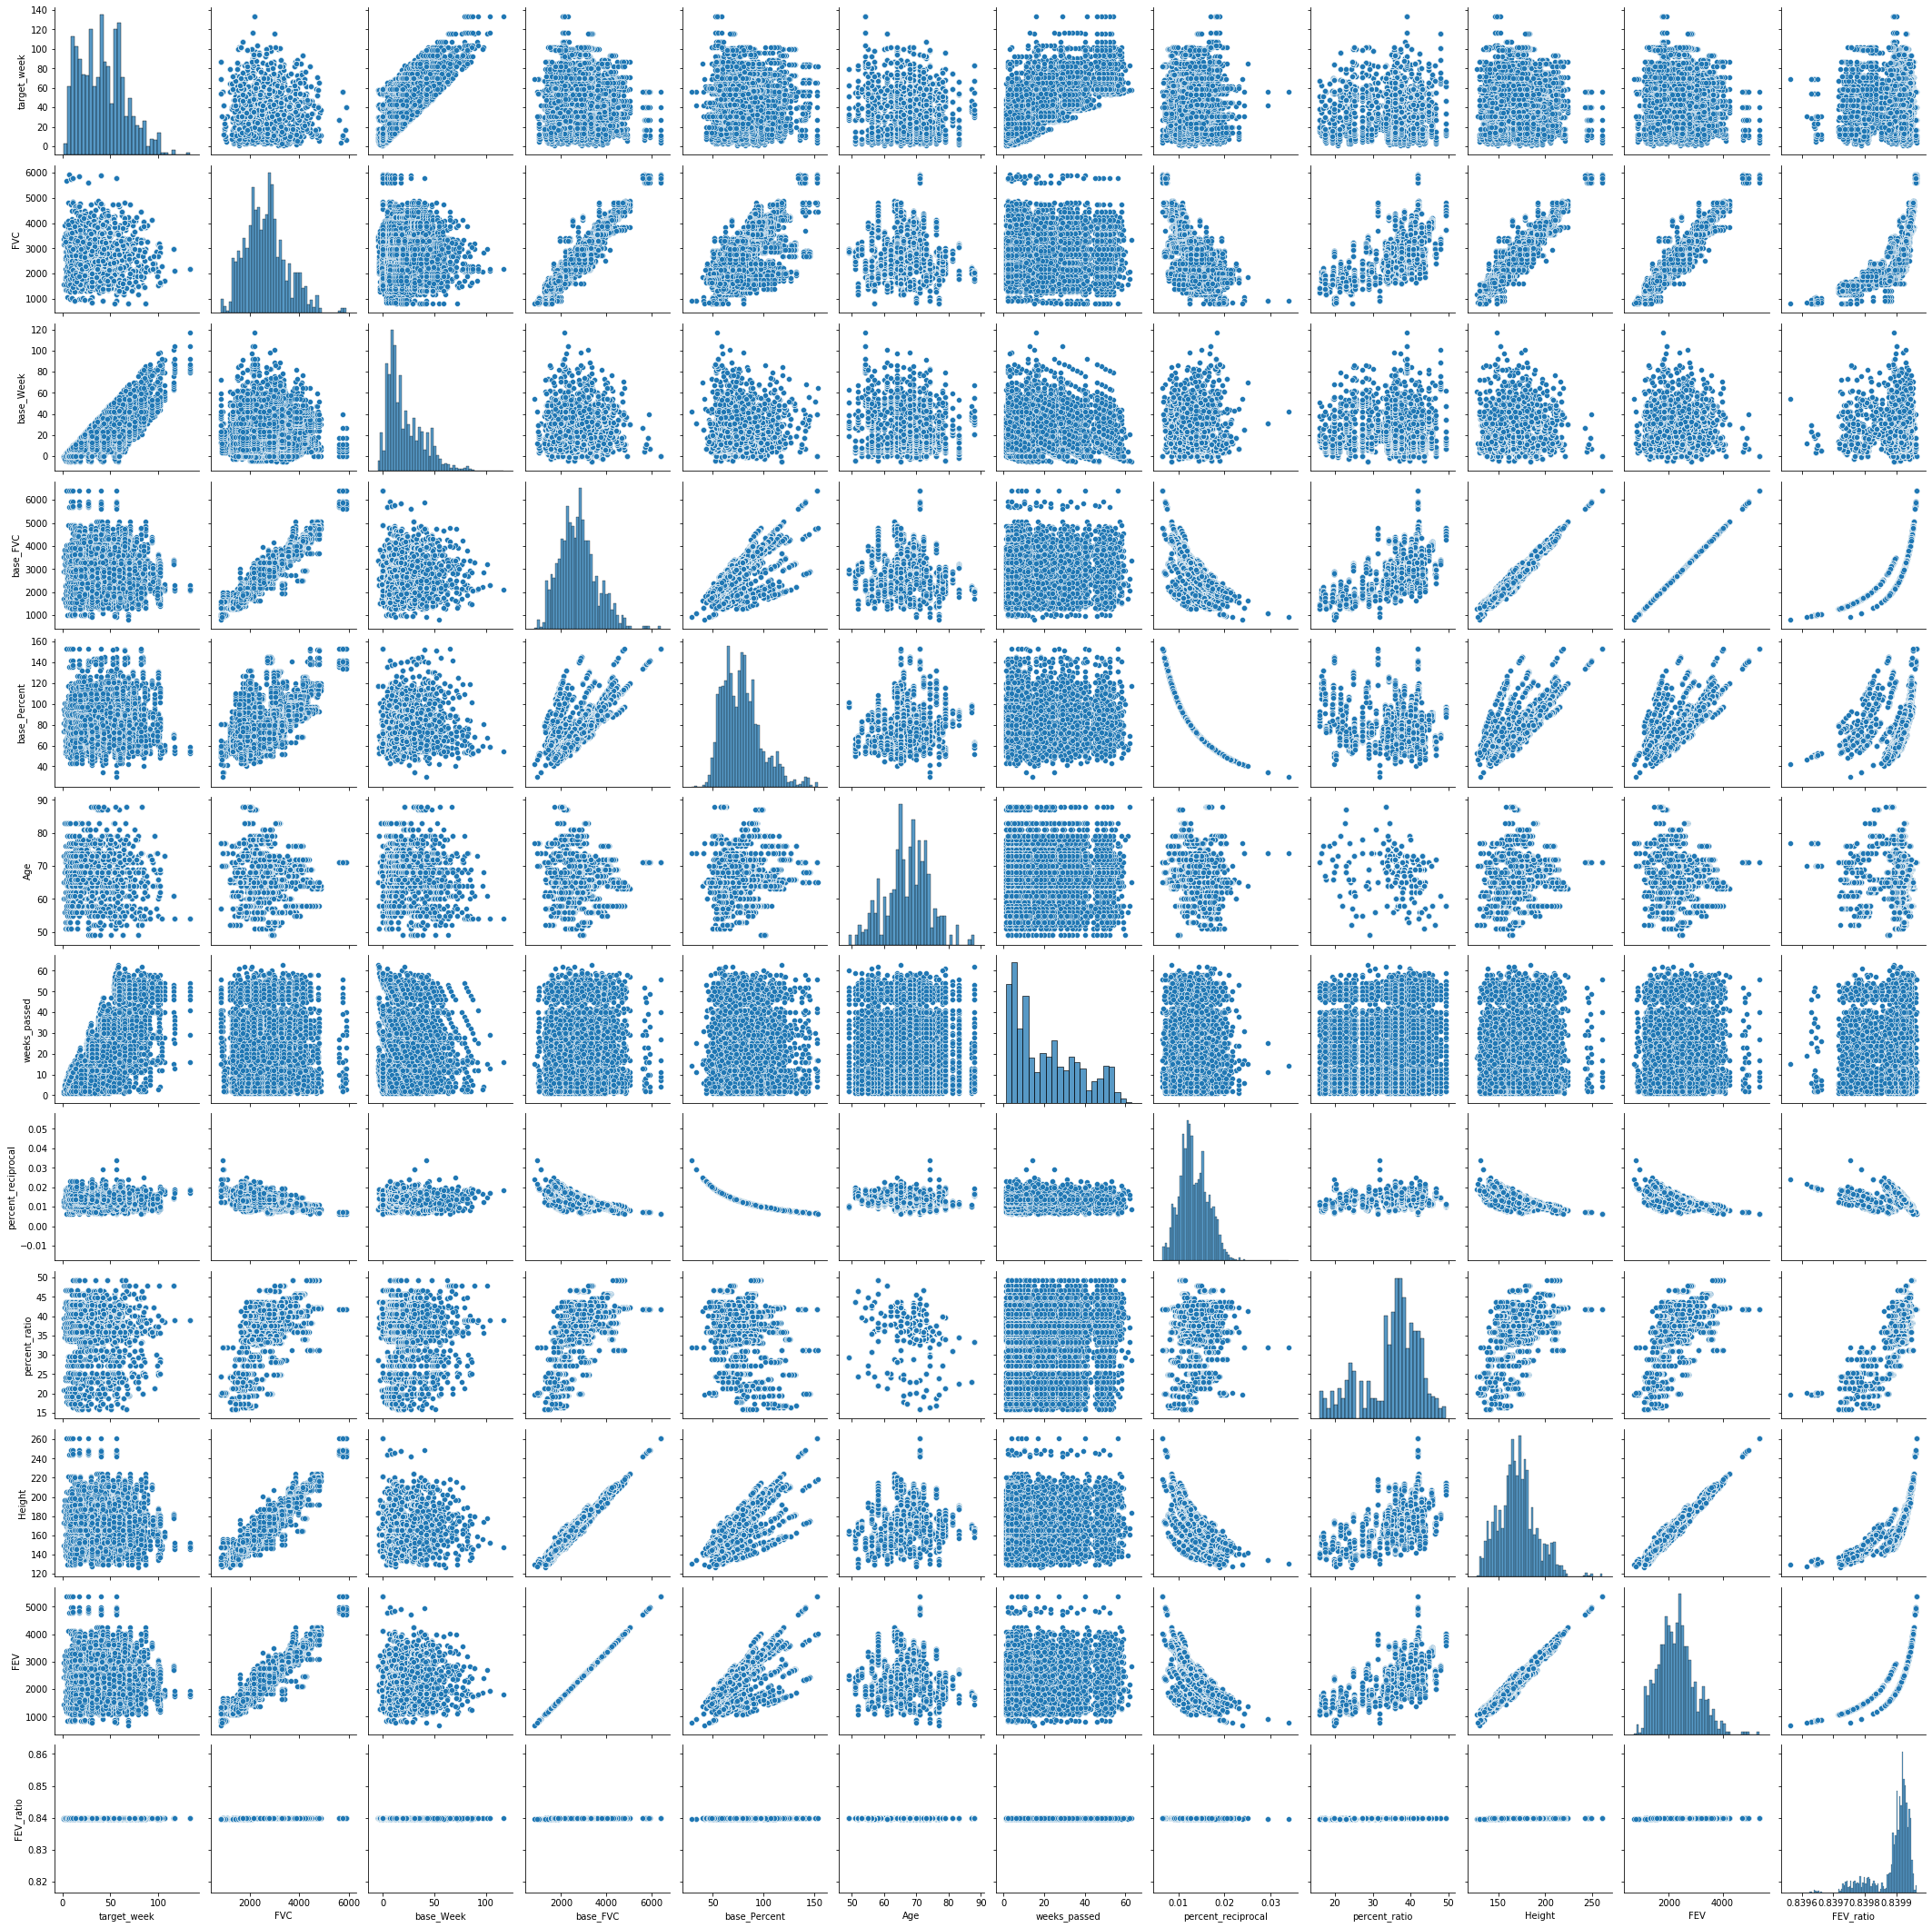

In [7]:
sns.pairplot(train_df)

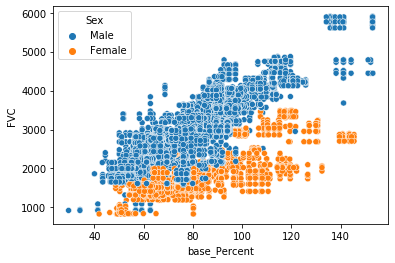

In [8]:
sns.scatterplot(x='base_Percent', y='FVC', hue='Sex', data=train_df)

In [9]:
(train_df.base_Percent - 100) * (train_df.target_week - train_df.base_Week) / 100 * 100

1        -375.717162
2        -459.209864
3        -542.702567
4        -626.195269
5        -876.673377
            ...     
13678    -644.966113
13679   -1074.943522
13687    -343.109714
13688    -800.589333
13697    -431.156075
Length: 6072, dtype: float64

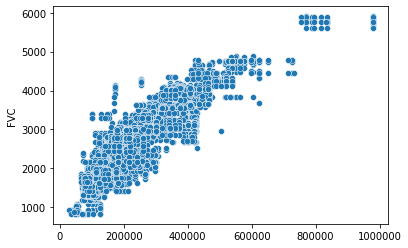

In [10]:
sns.scatterplot(x=train_df.base_Percent * train_df.base_FVC, y=train_df.FVC)

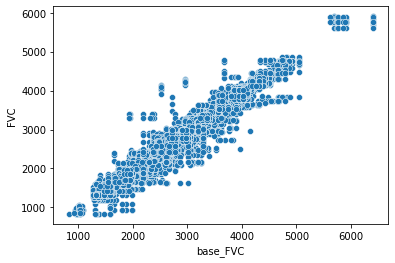

In [11]:
sns.scatterplot(x=train_df.base_FVC, y=train_df.FVC)

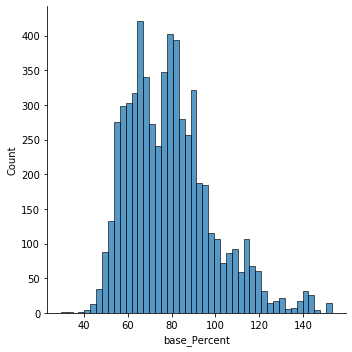

In [12]:
sns.displot(data=train_df.base_Percent)

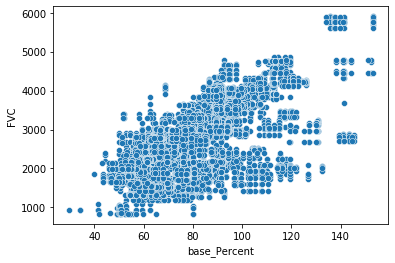

In [13]:
sns.scatterplot(x=train_df.base_Percent, y=train_df.FVC)

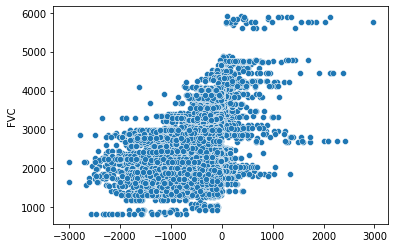

In [14]:
sns.scatterplot(x=(train_df.weeks_passed) * (train_df.base_Percent-100), y=train_df.FVC)